## 查看資料

In [7]:
# 讀入 train_info.csv
import pandas as pd

train_info = pd.read_csv('/Users/yuchingchen/Documents/AI_CUP/data/39_Training_Dataset/train_info.csv')

train_info.shape

(1955, 8)

In [12]:
# 看 value.count()

print(train_info["mode"].value_counts())
print(train_info["gender"].value_counts())
print(train_info["hold racket handed"].value_counts())
print(train_info["play years"].value_counts())
print(train_info["level"].value_counts())


mode
10    829
9     785
8      45
7      44
1      42
2      42
3      42
4      42
5      42
6      42
Name: count, dtype: int64
gender
1    1627
2     328
Name: count, dtype: int64
hold racket handed
1    1589
2     366
Name: count, dtype: int64
play years
1    868
2    700
0    387
Name: count, dtype: int64
level
5    903
2    715
3    201
4    136
Name: count, dtype: int64


## 視覺化

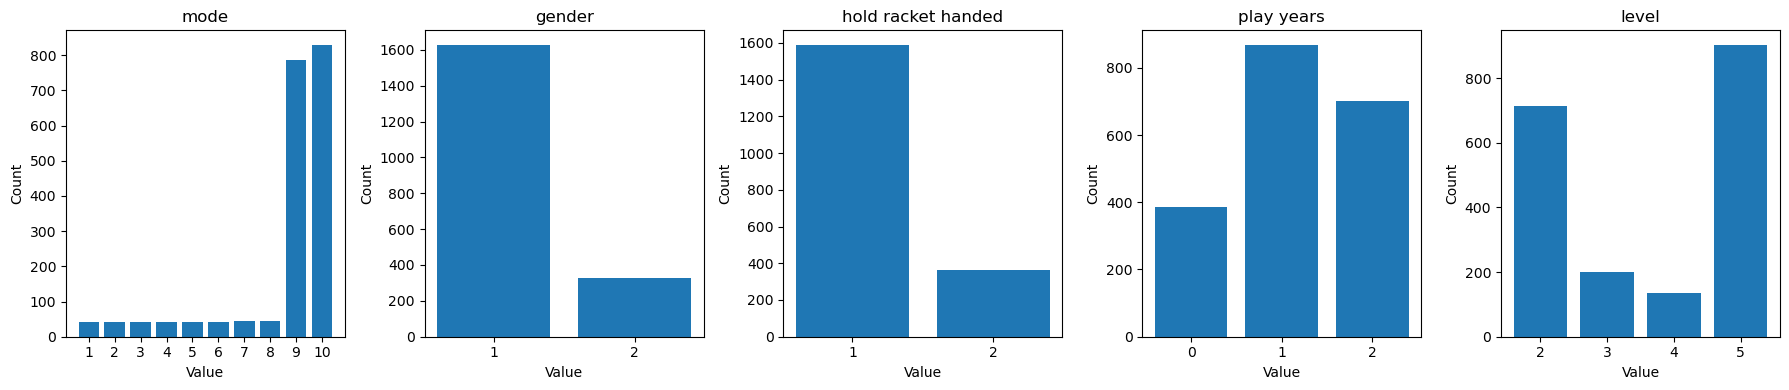

In [9]:
import matplotlib.pyplot as plt

# 要視覺化的欄位
columns = ['mode', 'gender', 'hold racket handed', 'play years', 'level']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

# 繪製每個欄位的 value_counts 圖
for i, col in enumerate(columns):
    counts = train_info[col].value_counts().sort_index()
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

## 資料特徵工程處理

In [9]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from joblib import Parallel, delayed

# === 資料路徑 ===
info_path       = "/Users/yuchingchen/Documents/AI_CUP/data/39_Training_Dataset/train_info.csv"
data_dir        = "/Users/yuchingchen/Documents/AI_CUP/data/39_Training_Dataset/train_data"
output_csv_path = "/Users/yuchingchen/Documents/AI_CUP/feature_engineering/train_features.csv"

# 1. 讀取 info
info_df = pd.read_csv(info_path, dtype={"unique_id": str})

def extract_34_features(segment):
    feats = []
    # 1. 軸向 mean, var, rms  (6×3 = 18)
    for i in range(6):
        x = segment[:, i]
        feats += [x.mean(), x.var(), np.sqrt((x**2).mean())]
    # 2. 整體 acc/gyro max, min, mean  (2×3 = 6)
    acc  = np.linalg.norm(segment[:, :3], axis=1)
    gyro = np.linalg.norm(segment[:, 3:], axis=1)
    for arr in (acc, gyro):
        feats += [arr.max(), arr.min(), arr.mean()]
    # 3. 群組 kurtosis, skewness, power, spectral entropy  (2×4 = 8)
    def spec_stats(arr):
        Xf      = np.abs(fft(arr))**2
        psd     = Xf / (Xf.sum() + 1e-12)
        power   = Xf.mean()
        entropy = -(psd * np.log(psd + 1e-12)).sum()
        return kurtosis(arr), skew(arr), power, entropy
    for arr in (acc, gyro):
        feats += list(spec_stats(arr))
    # 4. 軸向高階平均：mean(kurtosis), mean(skewness)  (2)
    kurt_ax = [kurtosis(segment[:, i]) for i in range(6)]
    skew_ax = [skew   (segment[:, i]) for i in range(6)]
    feats += [np.mean(kurt_ax), np.mean(skew_ax)]

    assert len(feats) == 34, f"維度錯誤：{len(feats)} != 34"
    return feats

def process_row(row):
    uid = row["unique_id"]
    # 解析切割點
    raw  = str(row["cut_point"]).strip("[]").split()
    cuts = list(map(int, raw))
    # 讀檔
    data = np.loadtxt(os.path.join(data_dir, f"{uid}.txt"))
    vec  = []
    # 對 27 段做特徵擷取
    for i in range(27):
        s, e = cuts[i], cuts[i+1]
        if e > data.shape[0]:
            return None
        vec += extract_34_features(data[s:e, :])
    # 加上 6 欄標籤
    vec += [
        uid,
        row["player_id"],
        row["gender"],
        row["hold racket handed"],
        row["play years"],
        row["level"]
    ]
    return vec

# 2. 並行處理所有列
results = Parallel(n_jobs=8, backend="loky")(
    delayed(process_row)(row) for _, row in info_df.iterrows()
)

# 過濾失敗的
rows = [r for r in results if r is not None]

# 3. 生成欄位名稱
n_total = len(rows[0])
n_feat  = n_total - 6
feat_cols  = [f"f{i}" for i in range(n_feat)]
label_cols = ["unique_id", "player_id", "gender", "hold racket handed", "play years", "level"]
columns    = feat_cols + label_cols

# 4. 輸出
df = pd.DataFrame(rows, columns=columns)
df.to_csv(output_csv_path, index=False)
print(f"✅ 特徵檔已輸出：{output_csv_path}，共 {df.shape[0]} 筆，每筆 {df.shape[1]} 欄")

✅ 特徵檔已輸出：/Users/yuchingchen/Documents/AI_CUP/feature_engineering/train_features.csv，共 1955 筆，每筆 924 欄
